In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
def resize_image(img_name):
  image = cv2.imread(f'/content/drive/MyDrive/{img_name}', 1)
  resized_image = cv2.resize(image, (512, 512))
  cv2.imwrite(f"/content/drive/MyDrive/resized_{img_name}", resized_image)

image_list = ['sample_cat.jpg', 'sample_dog.jpg']
for image in image_list:
  resize_image(image)

In [ ]:
def create_latents(num_imgs, dim, device):
  latent_codes = nn.Embedding(num_imgs, dim)
  latent_codes.weight = nn.Parameter(torch.randn(num_imgs, dim) / math.sqrt(dim/2))
  latent_codes = latent_codes.to(device = device)
  return latent_codes

In [ ]:
import torch
import math
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self, num_inputs):
    super(MLP, self).__init__()
    self.fcnemb = nn.Linear(256, 256)
    self.fcn1 = nn.Linear(num_inputs, 256)
    self.fcn2 = nn.Linear(256, 256)
    self.fcn3 = nn.Linear(256, 3)
    self.relu = nn.ReLU()
    self.sig = nn.Sigmoid()

  def forward(self, X, latent_code):
    Y = self.relu(self.fcnemb(latent_code))
    X = self.relu(self.fcn1(X))

    X  = X + Y
    X = self.relu(self.fcn2(X))
    X = self.relu(self.fcn2(X))
    X = self.relu(self.fcn2(X))
    X = self.relu(self.fcn2(X))
    X = self.sig(self.fcn3(X))
    return X


In [ ]:
import os
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import random

def input_mapping(x, B):
    x = torch.FloatTensor(x)
    x = x.to(device = device)
    #x = torch.from_numpy()
    if B is None:
        return x
    else:
        B = B.to(device = device)
        x_proj = (2.*np.pi*x) @ B.T
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class CustomDataset(Dataset):
    def __init__(self, n, img_path, B_gauss, latent_idx):
        self.X = []
        self.Y = []
        self.B_gauss = B_gauss
        self.latent_idx = latent_idx
        
        image = torchvision.io.read_image(img_path)
        _, height, width = image.shape
        image = image.numpy()
        
        for i in range(height):
          for j in range(width):
            self.X.append(np.array([i, j])/255.0)
            self.Y.append(image[:, i, j]/255.0)
        self.Y = [l.tolist() for l in self.Y]
        self.X = torch.FloatTensor(self.X).to(device = device)
        self.X = input_mapping(self.X, self.B_gauss)

        if n != None:
          self.X = self.X[:n]
          self.Y = self.Y[:n]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
      idx_sample = self.X[idx]
      idx_target = self.Y[idx]
      return {
          "x": torch.tensor(idx_sample, dtype = torch.float),
          "y": torch.tensor(idx_target, dtype = torch.float),
          "latent_idx" : self.latent_idx
      }


In [ ]:
def get_psnr(original_img, res_img):
  img1 = cv2.imread(f'/content/drive/MyDrive/{original_img}')
  img2 = cv2.imread(f'/content/drive/MyDrive/{res_img}')
  return cv2.PSNR(img1, img2)
  

In [ ]:
get_psnr("resized_dog.jpg", "resized_cat.jpg")

4.822846887292145

In [ ]:
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import torch.utils.data as data
dump_path = "/content/drive/MyDrive/dog_dump"
img0_path = "/content/drive/MyDrive/resized_sample_dog.jpg"
img1_path = "/content/drive/MyDrive/resized_sample_cat.jpg"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mapping_size = 256
B_gauss = torch.normal(0, 1, size=(mapping_size,2))
B_gauss = B_gauss*10

dataset0 = CustomDataset(None, img0_path, B_gauss, 0)
dataset1 = CustomDataset(None, img1_path, B_gauss, 1)
concat_dataset = ConcatDataset([dataset0, dataset1])
train_loader = DataLoader(concat_dataset, batch_size = 512)


num_epochs = 200
losses = []
euc = []
psnr0 = []
psnr1 = []

learning_rate = 0.0001
latents = create_latents(2, 256, device)
latents_copy = torch.clone(latents.weight)


model = MLP(mapping_size*2)
model = model.to(device=device)
model.train()
criterian = nn.MSELoss()


optimizer = torch.optim.AdamW([
            {'params': model.parameters(), 'lr': 0.0001},
            {'params': latents.parameters(), 'lr': 0.001},
        ])



X = []
image = torchvision.io.read_image(img1_path)
_, height, width = image.shape
image = image.numpy()
for i in range(height):
  for j in range(width):
    X.append(np.array([i, j])/255.0)
picture = torch.FloatTensor(X).to(device = device)
picture = input_mapping(picture, B_gauss)






for epoch in range(1, num_epochs+1):
  for data in train_loader:
    xtrain = data["x"].to(device = device)
    ytrain = data["y"].to(device = device)
    selected_latent = torch.tensor([data["latent_idx"][0]]).to(device = device)
    pred = model(xtrain, latents(selected_latent))
    loss = criterian(pred, ytrain)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(latents.weight.grad.max(), latents.weight.grad.mean())
  losses.append(loss.item())
  euc.append(criterian(latents_copy, latents.weight).item())
  
  with torch.no_grad():
    for i in range(0,2):
      picture_pred = model(picture, (latents(torch.tensor([i]))))
      picture_pred = picture_pred*255
      picture_pred = torch.reshape(picture_pred, (512, 512, 3))
      res = picture_pred.detach().cpu().numpy()
      res = res.astype(np.uint8)
      res = Image.fromarray(res, 'RGB')
      res.save(f"{dump_path}/latent_{i}_epoch{epoch}.jpg")
      if i == 0:
        psnr0.append(get_psnr("resized_sample_dog.jpg", f"dog_dump/latent_{i}_epoch{epoch}.jpg"))
      else:
        psnr1.append(get_psnr("resized_sample_cat.jpg", f"dog_dump/latent_{i}_epoch{epoch}.jpg"))


  print(f"epoch:{epoch}, loss = {loss.item():.4f}")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:1, loss = 0.0112
epoch:2, loss = 0.0095
epoch:3, loss = 0.0066
epoch:4, loss = 0.0083
epoch:5, loss = 0.0067
epoch:6, loss = 0.0059
epoch:7, loss = 0.0065
epoch:8, loss = 0.0063
epoch:9, loss = 0.0052
epoch:10, loss = 0.0041
epoch:11, loss = 0.0036
epoch:12, loss = 0.0036
epoch:13, loss = 0.0035
epoch:14, loss = 0.0035
epoch:15, loss = 0.0029
epoch:16, loss = 0.0032
epoch:17, loss = 0.0029
epoch:18, loss = 0.0028
epoch:19, loss = 0.0022
epoch:20, loss = 0.0017
epoch:21, loss = 0.0031
epoch:22, loss = 0.0015
epoch:23, loss = 0.0011
epoch:24, loss = 0.0018
epoch:25, loss = 0.0010
epoch:26, loss = 0.0013
epoch:27, loss = 0.0011
epoch:28, loss = 0.0009
epoch:29, loss = 0.0012
epoch:30, loss = 0.0007
epoch:31, loss = 0.0008
epoch:32, loss = 0.0013
epoch:33, loss = 0.0011
epoch:34, loss = 0.0014
epoch:35, loss = 0.0005
epoch:36, loss = 0.0012
epoch:37, loss = 0.0007
epoch:38, loss = 0.0007
epoch:39, loss = 0.0007
epoch:40, loss = 0.0006
epoch:41, loss = 0.0004
epoch:42, loss = 0.0013
e

In [ ]:
psnr0

[4.214943756014745,
 5.934699106728009,
 8.035490464968834,
 6.70841142187057,
 6.934004146013874,
 5.917926353062308,
 5.90067971711897,
 4.6468566926374555,
 8.134756437994428,
 10.022977963956926,
 9.347839684813351,
 7.255485282908309,
 7.348070872902557,
 7.478973859121099,
 7.301642554613252,
 7.180564053999681,
 7.240869095616796,
 7.60890763912311,
 8.43245978137628,
 8.4501455108411,
 8.155816937601656,
 8.176061289060343,
 8.653699681442529,
 9.070822755510367,
 8.94957088978324,
 9.363952450892395,
 8.545630823163439,
 8.549226682076638,
 8.820908837781037,
 9.139236784445364,
 9.289948116452157,
 9.37545150275444,
 9.668631862916893,
 9.602931061555438,
 9.930439613148792,
 9.345377206408266,
 9.965517519484447,
 9.485445528031256,
 9.969238927233476,
 10.185646486102051,
 10.564674860466601,
 10.874739223298649,
 11.777592316410054,
 12.201273749676178,
 10.900006202067141,
 12.545640983566413,
 12.542800594648273,
 13.318816026529703,
 13.169486197103947,
 11.813710928611

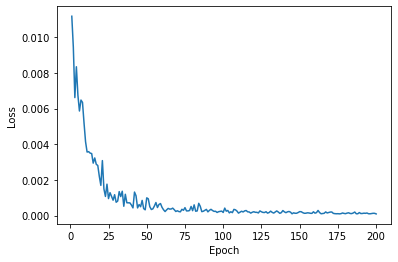

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = range(1, num_epochs+1)
y = losses
plt.plot(x, y)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
# X = []
# image = torchvision.io.read_image(img1_path)
# _, height, width = image.shape
# image = image.numpy()
# for i in range(height):
#   for j in range(width):
#     X.append(np.array([i, j])/255.0)
# picture = torch.FloatTensor(X).to(device = device)
# picture = input_mapping(picture, B_gauss)

In [ ]:
# picture_pred = model(picture, (latents(torch.tensor([1]))+ latents(torch.tensor([0])))/2)
# picture_pred = picture_pred*255
# picture_pred = torch.reshape(picture_pred, (256, 256, 3))
# res = picture_pred.detach().cpu().numpy()
# res = res.astype(np.uint8)
# res = Image.fromarray(res, 'RGB')
# res.save(f"{dump_path}/mean_latent.jpg")

In [ ]:
#compare PSNR, MSE